<a href="https://colab.research.google.com/github/vedoly/cadd-smart-systematic-literature-reviews/blob/main/drug_and_ml_smart_systematic_literature_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Get Data**

##Download Data

In [ ]:
filename = "csv-moleculeTi-set.csv"

import pandas as pd
df = pd.read_csv(filename)

In [ ]:
df.head(1)

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI
0,29750902,Machine learning in chemoinformatics and drug ...,"Lo YC, Rensi SE, Torng W, Altman RB.",Drug Discov Today. 2018 Aug;23(8):1538-1546. d...,Lo YC,Drug Discov Today,2018,2018/05/12,PMC6078794,NIHMS966325,10.1016/j.drudis.2018.05.010


In [ ]:
df = df[['PMID','Title','Journal/Book','Create Date']]

In [ ]:
len(df)

4597

## Get Keywords from PubMed

In [ ]:
import requests
import numpy as np

def getKeywords(pmid):
  try:
    page = requests.get("https://pubmed.ncbi.nlm.nih.gov/"+str(pmid) )
    from bs4 import BeautifulSoup
    soup = BeautifulSoup(page.content, 'html.parser')
    # print(soup)
    return soup.find_all(class_='abstract')[1].find_all('p')[-1].text
  except:
    return np.nan

In [ ]:
# around 10 min
df['keywords'] = df['PMID'].apply(lambda x: getKeywords(x))
df = df.dropna()

In [ ]:
df

,PMID,Title,Journal/Book,Create Date,keywords
0,29750902,Machine learning in chemoinformatics and drug ...,Drug Discov Today,2018/05/12,\n \n Chemoinformatics is an establi...
1,29887378,Next-Generation Machine Learning for Biologica...,Cell,2018/06/12,\n\n Keywords:\n \n \n ...
2,32084340,A Deep Learning Approach to Antibiotic Discovery,Cell,2020/02/22,\n\n Keywords:\n \n \n ...
3,31651216,Rethinking Drug Repositioning and Development ...,OMICS,2019/10/26,\n\n Keywords:\n \n \n ...
4,31294972,Concepts of Artificial Intelligence for Comput...,Chem Rev,2019/07/12,"\n \n Artificial intelligence (AI), ..."
...,...,...,...,...,...
4592,33561143,HIV incidence after pre-exposure prophylaxis i...,PLoS Med,2021/02/09,\n\n Trial registration:\n \n ...
4593,31219457,JoVE Methods Collection Highlights: Protein-Pr...,J Vis Exp,2019/06/21,\n \n Protein-protein interactions (...
4594,33036834,The future of Cochrane Neonatal,Early Hum Dev,2020/10/10,\n \n Cochrane Neonatal was first es...
4595,34158099,"A prospective, randomized, single-blinded, cro...",Trials,2021/06/23,\n\n Keywords:\n \n \n ...


In [ ]:
df.to_csv("drug_keywords.csv",index=False)

In [ ]:
df = pd.read_csv("drug_keywords.csv")

# **Preprocessing Data**

In [ ]:
df['temp'] = df['keywords'].apply(lambda x: x[0:20])
df = df[ df['temp'] == '\n\n          Keywords']
df = df.drop(columns=['temp'])

In [ ]:
df['keywords'] = df['keywords'].apply(lambda x:x.strip()[31:-1])

In [ ]:
df['keywords'] = df['keywords'].apply(lambda x:[e.strip() for e in x.split(";")])

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')

def cleanText(text):
  # text = " ".join(text)
  text = [e.lower() for e in text]
  text = [re.sub("[^-9A-Za-z ]", "" , e) for e in text]

  text = [nltk.PorterStemmer().stem(word) for word in text]
  text = [nltk.WordNetLemmatizer().lemmatize(word) for word in text]
  return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['keywords'] = df['keywords'].apply(lambda x: cleanText(x))

In [ ]:
from nltk import flatten
print("unique keywords count: ",len(set(flatten(df['keywords'].tolist()))))

unique keywords count:  7141


In [ ]:
from collections import Counter
keywords_count = Counter(flatten(df['keywords'].tolist()))

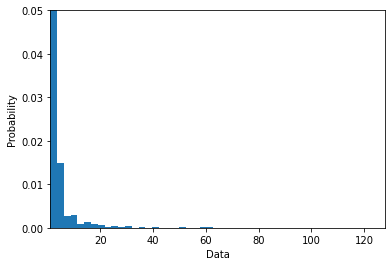

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


x = keywords_count.values()
plt.axis([1, 128, 0, 0.05]) 
plt.hist(x, density=True, bins=500)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');


In [ ]:
most_keywords = [key for key in keywords_count.keys() if keywords_count[key] > 5]
len(most_keywords)

286

In [ ]:
mkw2idx = dict(zip(most_keywords,range(len(most_keywords))))

In [ ]:
import numpy as np
def createCatArray(arr):
  out = np.zeros((len(mkw2idx)),dtype=int)
  for e in arr:
    if e in mkw2idx:
      out[mkw2idx[e]] = 1
  return out

In [ ]:
df['cat_features'] = df['keywords'].apply(lambda x: createCatArray(x))

In [ ]:
df

,PMID,Title,Journal/Book,Create Date,keywords,cat_features
1,29887378,Next-Generation Machine Learning for Biologica...,Cell,2018/06/12,"[machine lean, deep learn, network biolog, neu...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,32084340,A Deep Learning Approach to Antibiotic Discovery,Cell,2020/02/22,"[antibiotic resist, antibiotic toler, antibiot...","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,31651216,Rethinking Drug Repositioning and Development ...,OMICS,2019/10/26,"[artificial intellig, drug develop, drug repos...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
5,31374225,Machine learning and data mining frameworks fo...,Pharmacol Ther,2019/08/03,"[association rule min, data min, drug response...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, ..."
7,30200333,Machine Learning for Drug-Target Interaction P...,Molecules,2018/09/12,"[drug discoveri, drug-target interaction predi...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
4532,33746790,Treatment Response Prediction and Individualiz...,Front Psychiatry,2021/03/22,"[classif, graph metr, methamphetamine depend, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4533,28960172,Resting-state functional magnetic resonance im...,J Neurosurg Pediatr,2017/09/30,"[aed antiepileptic drug, bold blood-oxygen l...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4535,32885678,Prioritizing Candidates of Post-Myocardial Inf...,Circulation,2020/09/05,"[heart failur, myocardial infarct, proteom, tr...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4537,31132237,Identification of Novel Allosteric Modulators ...,ACS Chem Neurosci,2019/05/28,[--chloro---dioxo--dihydro--isoindol--ylmethyl...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# **Analyze Data**

In [ ]:
X = df.cat_features.tolist()

In [ ]:
pca_components = 2

from sklearn.decomposition import PCA
pca = PCA(n_components=pca_components)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = list(range(pca_components)))

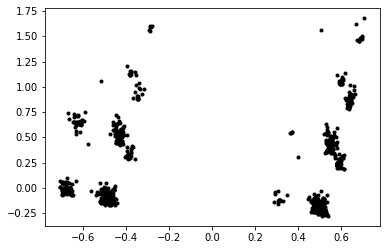

In [ ]:
x = principalDf[0]
y = principalDf[1]

plt.plot(x, y, '.', color='black');